In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Memoria GPU configurada correctamente")
    except RuntimeError as e:
        print(e)

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Memoria GPU configurada correctamente


In [3]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt

In [4]:
# Cargar el mapa de profundidades extraído con OCR
depth_df = pd.read_csv("depth_map.csv")

# Convertirlo a diccionario para lookup rápido
depth_map = dict(zip(depth_df["image_name"], depth_df["depth_cm"]))

print("Escalas cargadas:", len(depth_map))

BASE_IMG = r"../data/processed"
BASE_OUT = r"../data/pred_masks_UNetPlusPlus"

centers = ["Albacete","Barcelona","Caceres","Getafe","Goya_Madrid","Guadalajara","La_Paz","Navarra","Salamanca"]

TARGET_SIZE = (384, 384)

Escalas cargadas: 4586


In [5]:
#1. Funciones auxiliares


def load_image(path):
    #Cargar imagen
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    img = cv2.resize(img, TARGET_SIZE)
    img = np.expand_dims(img, axis=-1)
    return img

def save_mask(mask, path):
    #Guardar máscara predicha
    os.makedirs(os.path.dirname(path), exist_ok=True)
    mask = (mask * 255).astype(np.uint8)
    cv2.imwrite(path, mask)

In [6]:
#2. Cargar modelo entrenado
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2*inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_coef(y_true, y_pred)
    return bce + (1 - dice)

model = tf.keras.models.load_model(
    "unetpp_final.h5",
    custom_objects={"dice_coef": dice_coef, "bce_dice_loss": bce_dice_loss}
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
#3. Listar todas las imágenes del dataset completo
all_images = []

for c in centers:
    folder = os.path.join(BASE_IMG, c)
    files = glob(os.path.join(folder, "*.jpeg"))
    for f in files:
        all_images.append((c, f))

len(all_images)

4586

In [8]:
#4. Inferencia masiva
for center, img_path in all_images:

    fname = os.path.basename(img_path).replace(".jpeg", ".png")
    out_path = os.path.join(BASE_OUT, center, fname)

    if os.path.exists(out_path):
        continue

    img = load_image(img_path)
    pred = model.predict(img[None,...])[0,...,0]

    mask_bin = (pred > 0.5).astype(np.uint8)

    save_mask(mask_bin, out_path)

print("Inferencia completada.")

1/1 [==============================] - 0s 25ms/step
Inferencia completada.


In [9]:
#5. Funciones para extraer parámetros morfométricos

def compute_area(mask):
    #Área del músculo en píxeles
    return np.sum(mask == 1)

def compute_thickness(mask):
    #Grosor muscular (altura máxima del músculo)
    rows = np.where(np.sum(mask, axis=1) > 0)[0]
    if len(rows) == 0:
        return 0
    return rows[-1] - rows[0]

def thickness_px_to_cm(thickness_px, depth_cm):
    mm_per_px = (depth_cm * 10) / 384.0
    return (thickness_px * mm_per_px) / 10.0  # mm → cm

def compute_width(mask):
    #Anchura muscular (anchura máxima horizontal)
    cols = np.where(np.sum(mask, axis=0) > 0)[0]
    if len(cols) == 0:
        return 0
    return cols[-1] - cols[0]

def area_px_to_cm2(area_px, depth_cm):
    """
    Convierte área en píxeles a cm² usando la profundidad real del ecógrafo.
    
    depth_cm: escala vertical mostrada en la imagen original (ej. 6.0, 5.9, 7.0)
    La altura de la imagen procesada es 384 px.
    """
    mm_per_px = (depth_cm * 10) / 384.0   # cm → mm
    mm2_per_px2 = mm_per_px ** 2
    cm2_per_px2 = mm2_per_px2 / 100.0     # 100 mm² = 1 cm²
    return area_px * cm2_per_px2


In [10]:
#6. Procesar todas las máscaras predichas y extraer métricas

results = []

for center, img_path in all_images:

    image_name = os.path.basename(img_path)
    mask_name = image_name.replace(".jpeg", ".png")
    mask_path = os.path.join(BASE_OUT, center, mask_name)

    # Cargar máscara generada
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    mask_bin = (mask > 127).astype(np.uint8)

    # Métricas en px
    area_px = np.sum(mask_bin == 1)
    thickness_px = compute_thickness(mask_bin)

    # PROFUNDIDAD REAL DE ESTA IMAGEN
    depth_cm = depth_map.get(image_name, 6.0)   # fallback seguro

    # CONVERSIONES A UNIDADES FÍSICAS
    area_cm2 = area_px_to_cm2(area_px, depth_cm)
    thickness_cm = thickness_px_to_cm(thickness_px, depth_cm)

    results.append({
        "center": center,
        "image": img_path,
        "mask": mask_path,
        "depth_cm": depth_cm,
        "area_px": area_px,
        "area_cm2": round(area_cm2, 3),
        "thickness_px": thickness_px,
        "thickness_cm": round(thickness_cm, 3)
    })

df = pd.DataFrame(results)
df.to_csv("muscle_metrics_with_depth_UNetPlusPlus.csv", index=False)
df.head()

,center,image,mask,depth_cm,area_px,area_cm2,thickness_px,thickness_cm
0,Albacete,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,6.0,18725,4.572,90,1.406
1,Albacete,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,6.0,11696,2.855,114,1.781
2,Albacete,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,6.0,13438,3.281,94,1.469
3,Albacete,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,6.0,4221,1.031,152,2.375
4,Albacete,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...,6.0,12195,2.977,98,1.531


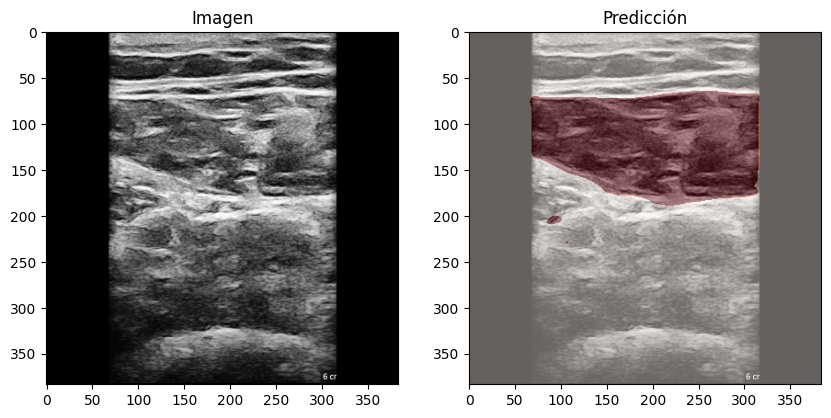

In [11]:
#7. Visualización de ejemplo

sample = df.sample(1).iloc[0]

img = cv2.imread(sample["image"], cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(sample["mask"], cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Imagen")

plt.subplot(1,2,2)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='Reds', alpha=0.4)
plt.title("Predicción")

plt.show()

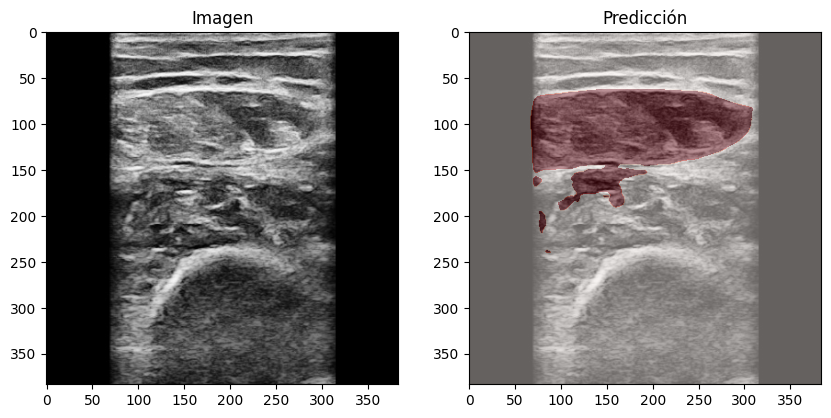

In [1]:
# =========================
# 7. Visualización de ejemplo (imagen concreta)
# =========================

import os
import cv2
import matplotlib.pyplot as plt

# Rutas base
img_dir = r"../data/processed/La_Paz"
mask_dir = r"../data/pred_masks_UNetPlusPlus/La_Paz"

# Nombres de archivo
img_name = "capture_8_2024-05-07T10-38-05.jpeg"
mask_name = "capture_8_2024-05-07T10-38-05.png"

# Rutas completas
img_path = os.path.join(img_dir, img_name)
mask_path = os.path.join(mask_dir, mask_name)

# Cargar imagen y máscara
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Imagen")

plt.subplot(1,2,2)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='Reds', alpha=0.4)
plt.title("Predicción")

plt.show()